In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ccdproc

from ccdproc import ImageFileCollection as IFC
from astropy.nddata import CCDData
from astropy.modeling import models, fitting, powerlaws
from astropy import units as u
from astropy import constants as const

from scipy.stats import linregress
from scipy.optimize import curve_fit

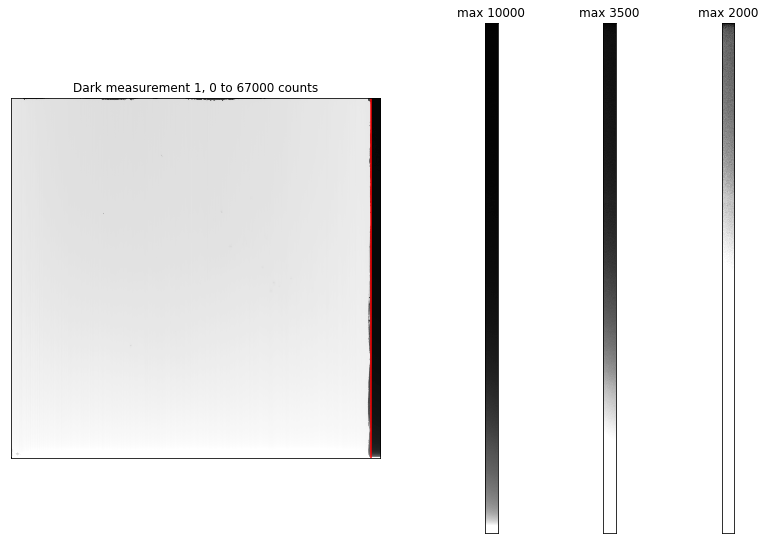

Bias of the 1. image:  2037.0 +/- 3678.3


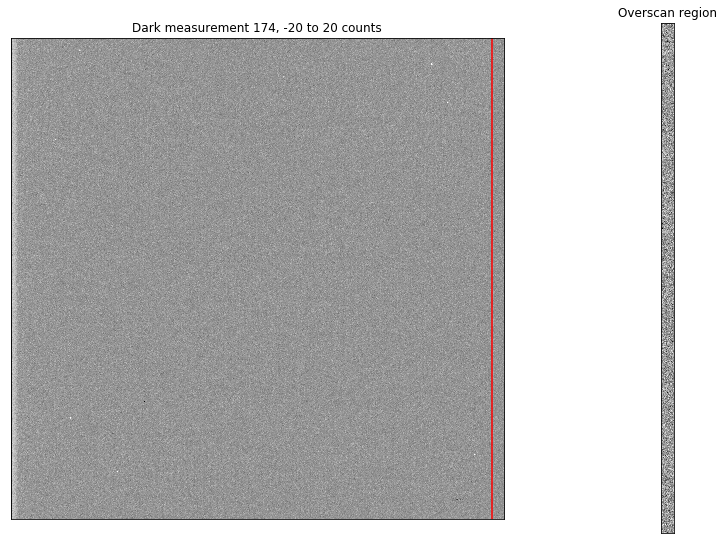

Bias of the last image:  1350.0 +/- 1.7


In [2]:
# from dark measurement read temperature and count median, standard deviation
# To read .fits file use IFC(<path_to_files>, glob_include = file name start*, keywords = interested key in header)
# The structure of a .fits file is Header Data Units(HDU)
# Each HDU contains .header (header information ~ key-value pair, labels of data) and .data 
# To get value of header information use IFC(...).values(<key>) or IFC(...).summary[<key>].data
# More info: https://ccdproc.readthedocs.io/en/latest/api/ccdproc.ImageFileCollection.html#ccdproc.ImageFileCollection.hdus
path = r".\Template Scripts\darks"
dark = IFC(path,glob_include='dark_*', keywords=['ccdtemp','datamedi','datastdv']) 
temp,med,stddev=np.asarray(dark.values("ccdtemp"))+273.15,np.asarray(dark.values("datamedi")),np.asarray(dark.values("datastdv"))

# use program ds9 we read the overscan region(= bias region) for dark_0000.fits is about [1025:1050]
# a list of median bias values and the standard deviations in the overscan region
bias_med = []
bias_std = []

path = r".\Template Scripts\darks-bias"
for idx, hdu in enumerate(dark.hdus(save_with_name = "-bias",
                                    save_location = path, overwrite = True)):
    bias = CCDData(hdu.data[0:1024,1025:1050], unit="electron")
    bias_med.append(np.median(np.asarray(bias)))
    bias_std.append(np.std(np.asarray(bias)))
    # Correct each of the dark measurements with their corresponding median bias value
    hdu.data = hdu.data - np.median(np.asarray(bias))
    if idx == 0:
        # plot of the whole image
        pic = CCDData(hdu.data, unit="electron") # convert hdu(array) to pic(CCDData) first
        ax1 = plt.subplot2grid((1,7),(0,0),colspan=4)
        ax2 = plt.subplot2grid((1,7),(0,4))
        ax3 = plt.subplot2grid((1,7),(0,5))
        ax4 = plt.subplot2grid((1,7),(0,6))
        ax1.imshow(pic, cmap='Greys_r', origin='lower left')
        ax1.axvline(x=1024,color='red')
        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.set_title("Dark measurement " + str(idx+1) + ", 0 to 67000 counts")
        # plot of overscan region
        ax2.imshow(bias, cmap='Greys_r', origin='lower left',vmax=10000)
        ax2.set_title("max 10000")
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.xaxis.set_major_locator(plt.NullLocator())
        # more overscan
        ax3.imshow(bias, cmap='Greys_r', origin='lower left',vmax=3500)
        ax3.set_title("max 3500")
        ax3.yaxis.set_major_locator(plt.NullLocator())
        ax3.xaxis.set_major_locator(plt.NullLocator())
        ax4.imshow(bias, cmap='Greys_r', origin='lower left',vmax=2000)
        ax4.set_title("max 2000")
        ax4.yaxis.set_major_locator(plt.NullLocator())
        ax4.xaxis.set_major_locator(plt.NullLocator())
        plt.tight_layout()
        plt.gcf().set_size_inches(11.69, 8.27)
        plt.savefig(r".\pictures\darkbias1.png",)
        plt.show()
        print("Bias of the 1. image: ", bias_med[0], "+/-", round(bias_std[0],1))
    if idx == 173:
        # plot of the whole image
        pic = CCDData(hdu.data, unit="electron") # convert hdu(array) to pic(CCDData) first
        ax1 = plt.subplot2grid((1,3),(0,0),colspan=2)
        ax2 = plt.subplot2grid((1,3),(0,2))
        ax1.imshow(pic, cmap='Greys_r', origin='lower left',vmin=-20, vmax=20)
        ax1.axvline(x=1024,color='red')
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.set_title("Dark measurement " + str(idx+1) + ", -20 to 20 counts")
        # plot of overscan region
        ax2.imshow(bias, cmap='Greys_r', origin='lower left')
        ax2.set_title("Overscan region")
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.xaxis.set_major_locator(plt.NullLocator())
        plt.tight_layout()
        plt.gcf().set_size_inches(11.69, 8.27)
        plt.savefig(r".\pictures\darkbias2.png",)
        plt.show()
        print("Bias of the last image: ", bias_med[-1], "+/-", round(bias_std[-1],1))


In [3]:
# Extract the median dark current values of the bias-subtracted FITS files of the dark measurements
path = r".\Template Scripts\darks-bias"
dark_no_bias = IFC(path,glob_include='dark_*', keywords=['datamedi', 'datastdv']) 

med_no_bias = []
stddev_no_bias = []
# use program ds9 we read the image region for dark_0000.fits is about (row[30:1014] colomn[0:1010])
for hdu in dark_no_bias.hdus():
    img = CCDData(hdu.data[0:1024,0:1020], unit="electron")
    med_no_bias.append(np.median(np.asarray(img)))
    stddev_no_bias.append(np.std(np.asarray(img)))

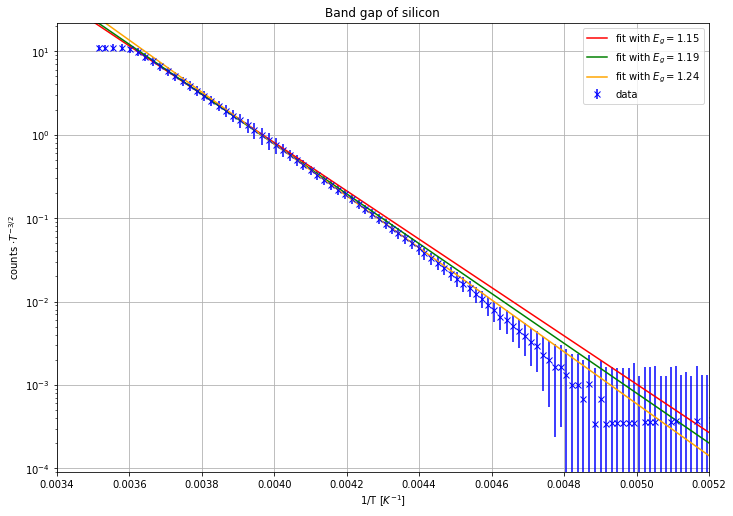

Parameter Errors are small: 0.003 0.002 0.003
Hence we use Error from the varying fitranges
Band gap of silicon =  1.19 +\- 0.04 eV
Literature value = 1.15 eV


In [4]:
# dark measurement analysis
# Verify the dependency according to eq. 14 by plotting the data and the theoretical curve 
def expon(x,A,k): 
    return A*np.exp(x*k)
xtemp = np.linspace(0.0034,0.0052,1000)

aa = 100
bb = 5
para, paraerr = curve_fit(expon, 1/temp[bb:aa], (med_no_bias*temp**(-3/2))[bb:aa], 
                          p0 = (3.2e10, -6000))
E_g1 = para[1]*u.K*(-2*const.k_B)
E_g_err1 = np.sqrt(paraerr[1][1])*u.K*(2*const.k_B)
plt.plot(xtemp, expon(xtemp, *para), label='fit with $E_g =$'+str(round(E_g1.to(u.eV).value,2)),
         color='red')

         
aa = 100
bb = 10
para, paraerr = curve_fit(expon, 1/temp[bb:aa], (med_no_bias*temp**(-3/2))[bb:aa], 
                          p0 = (3.2e10, -6000))
E_g2 = para[1]*u.K*(-2*const.k_B)
E_g_err2 = np.sqrt(paraerr[1][1])*u.K*(2*const.k_B)
plt.plot(xtemp, expon(xtemp, *para), label='fit with $E_g =$'+str(round(E_g2.to(u.eV).value,2)),
         color='green')

aa = 70
bb = 25
para, paraerr = curve_fit(expon, 1/temp[bb:aa], (med_no_bias*temp**(-3/2))[bb:aa], 
                          p0 = (3.2e10, -6000))
E_g3 = para[1]*u.K*(-2*const.k_B)
E_g_err3 = np.sqrt(paraerr[1][1])*u.K*(2*const.k_B)
plt.plot(xtemp, expon(xtemp, *para), label='fit with $E_g =$'+str(round(E_g3.to(u.eV).value,2)),
         color='orange')

plt.errorbar(1/temp[0:100], (med_no_bias*temp**(-3/2))[0:100],
    yerr=(stddev_no_bias*temp**(-3/2))[0:100],marker='x', ls='none', color='blue', label = 'data')
plt.xlabel("1/T [$K^{-1}$]")
plt.ylabel("counts $\cdot T^{-3/2}$")
plt.yscale('log')
plt.title("Band gap of silicon")
plt.axis([0.0034, 0.0052, 9e-5, 22])
plt.legend()
plt.grid()
plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig(r".\pictures\BandGap.png",)
plt.show()
# Determine the band gap of the detector chip by fitting the dependency.
print("Parameter Errors are small:",round(E_g_err1.to(u.eV).value,3),round(E_g_err2.to(u.eV).value,3),
     round(E_g_err3.to(u.eV).value,3))
print("Hence we use Error from the varying fitranges")
print("Band gap of silicon = ",round(E_g2.to(u.eV).value,2),"+\-",
      round(0.5*(E_g2.to(u.eV).value-E_g1.to(u.eV).value+E_g3.to(u.eV).value-E_g2.to(u.eV).value),2), 
      "eV")
print("Literature value = 1.15 eV")

# TODO: Discuss reasons for possible deviations from the expected band gap value.

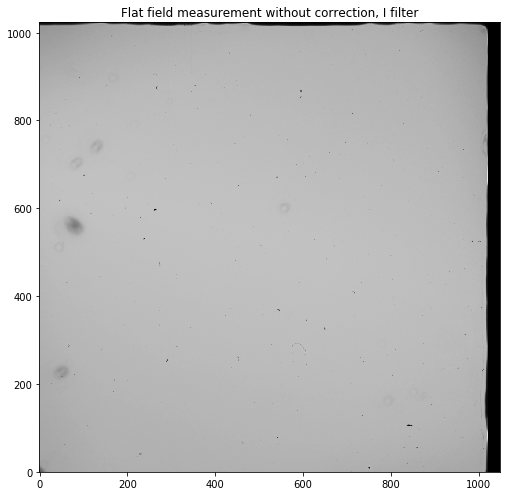

0.010023276803952307


C:\Users\Color\Documents\Anaconda\lib\site-packages\astropy\units\quantity.py:461: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Color\Documents\Anaconda\lib\site-packages\astropy\units\quantity.py:461: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


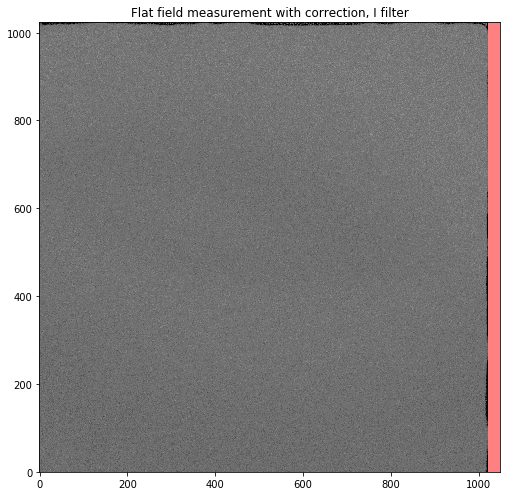

0.009074488216067435
0.009559623051830373


In [5]:
# read flat field measurement
path = r".\Template Scripts\flats"
flat_I = IFC(path,glob_include='flat_I_*',glob_exclude='*test*', keywords=['exptime', 'ccdtemp'])
flat_V = IFC(path,glob_include='flat_V_*', keywords=['exptime', 'ccdtemp'])
flat_R = IFC(path,glob_include='flat_R_*',glob_exclude='*test*', keywords=['exptime', 'ccdtemp'])

lower_bound = 211

# I filter
flat_list = []
for idx, hdu in enumerate(flat_I.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    if idx == 0:
        plt.imshow(dat, cmap='Greys_r', origin='lower')
        plt.title("Flat field measurement without correction, I filter")
        plt.gcf().set_size_inches(11.69, 8.27)
        plt.savefig(r".\pictures\FlatIFits.png",)
        plt.show()
    # subtract the bias from the individual flat-field images
    bias = np.median(CCDData(hdu.data[0:1024,1025:1050], unit="electron"))
    dat.data = dat.data - bias
    flat_list.append(dat)
    
# Combine the individual flat-field images to a single image (the master flatfield) 
read_out_I = np.asarray(ccdproc.Combiner(flat_list).median_combine())
read_out_I[read_out_I < lower_bound] = 0
print(lower_bound/np.median(read_out_I))
# normalize the master flat-field by dividing it by its median (why?)
master_flat_I = read_out_I/np.median(read_out_I)

for idx, hdu in enumerate(flat_I.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    dat.data = dat.data - bias
    # Perform a flat-field correction (i.e., divide the image by the normalized master flat-field)
    dat.data = dat.divide(master_flat_I)
    current_cmap = cm.get_cmap('Greys_r')
    current_cmap.set_bad(color='red',alpha=0.5)
    plt.imshow(dat, cmap='Greys_r',origin='lower', vmax=22000,vmin=20500)
    plt.title("Flat field measurement with correction, I filter")
    plt.gcf().set_size_inches(11.69, 8.27)
    plt.savefig(r".\pictures\FlatIFitsMasterCorrected.png",)
    plt.show()
    break  

# V filter
flat_list = []
for idx, hdu in enumerate(flat_V.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    # subtract the bias from the individual flat-field images
    bias = np.median(CCDData(hdu.data[0:1024,1025:1050], unit="electron"))
    dat.data = dat.data - bias
    flat_list.append(dat)
    
# Combine the individual flat-field images to a single image (the master flatfield)
read_out_V = np.asarray(ccdproc.Combiner(flat_list).median_combine())
read_out_V[read_out_V < lower_bound] = 0
print(lower_bound/np.median(read_out_V))
# normalize the master flat-field by dividing it by its median (why?)
master_flat_V = read_out_V/np.median(read_out_V)

# R filter
flat_list = []
for idx, hdu in enumerate(flat_R.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    # subtract the bias from the individual flat-field images
    bias = np.median(CCDData(hdu.data[0:1024,1025:1050], unit="electron"))
    dat.data = dat.data - bias
    flat_list.append(dat)
    
# Combine the individual flat-field images to a single image (the master flatfield)
read_out_R = np.asarray(ccdproc.Combiner(flat_list).median_combine())
read_out_R[read_out_R < lower_bound] = 0
print(lower_bound/np.median(read_out_R))
# normalize the master flat-field by dividing it by its median (why?)
master_flat_R = read_out_R/np.median(read_out_R)

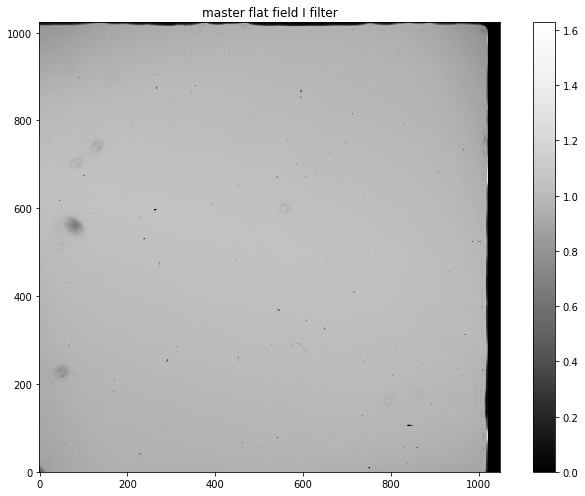

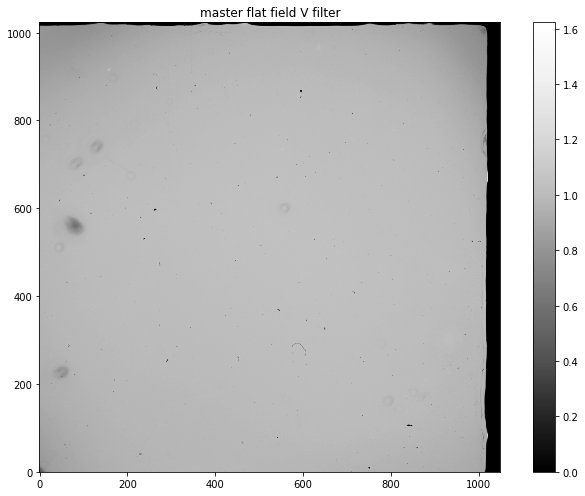

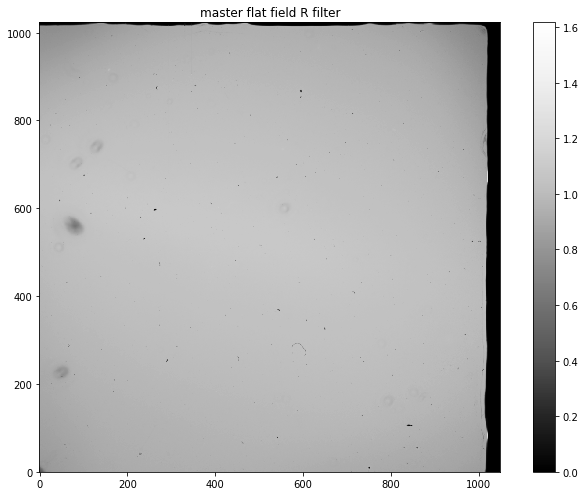

In [6]:
plt.imshow(master_flat_I, origin='lower',cmap='Greys_r')
plt.title("master flat field I filter")
plt.colorbar()
plt.gcf().set_size_inches(11.69, 8.27)
plt.show()

plt.imshow(master_flat_V, origin='lower',cmap='Greys_r')
plt.title("master flat field V filter")
plt.colorbar()
plt.gcf().set_size_inches(11.69, 8.27)
plt.show()

plt.imshow(master_flat_R, origin='lower',cmap='Greys_r')
plt.title("master flat field R filter")
plt.colorbar()
plt.gcf().set_size_inches(11.69, 8.27)
plt.show()

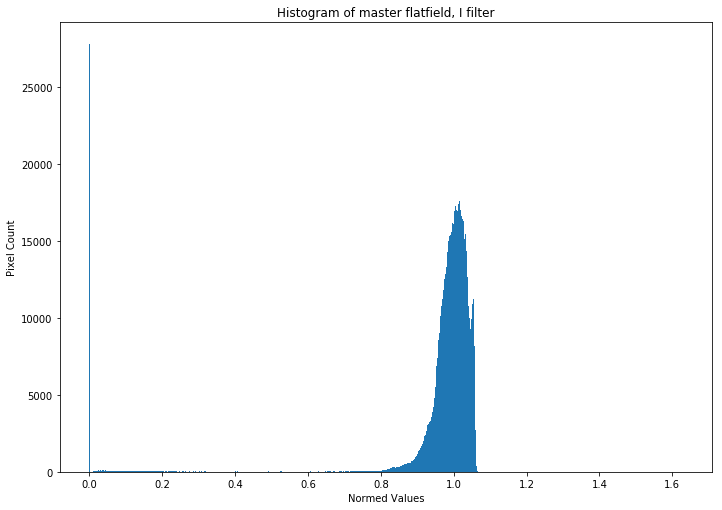

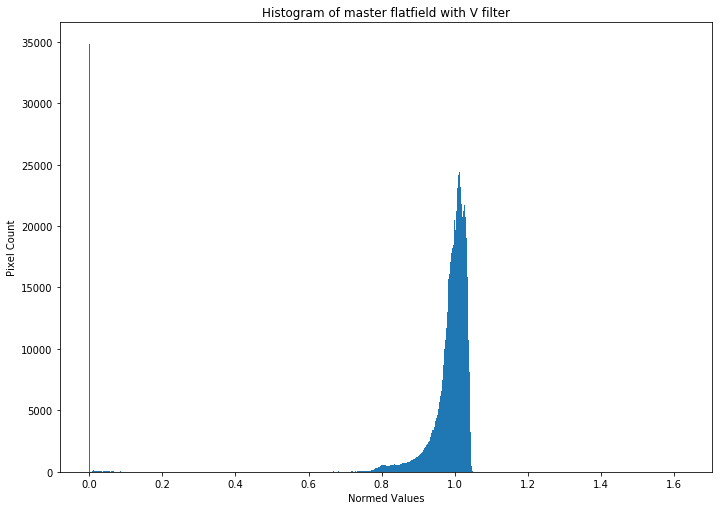

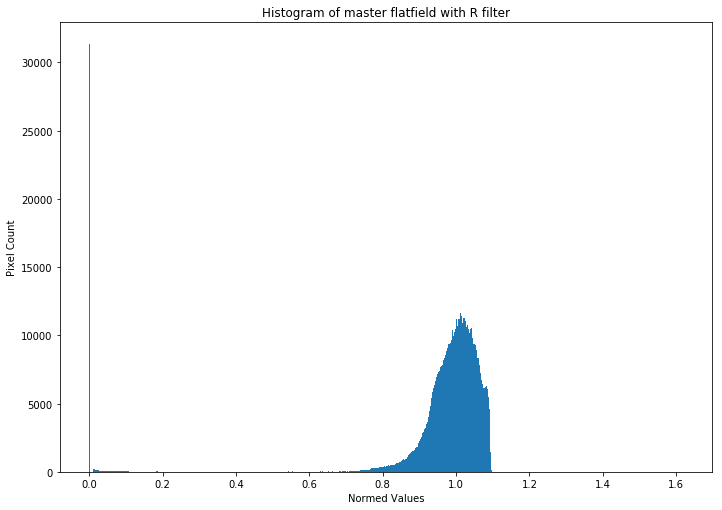

In [7]:
# obtain a histogram for this master flatfield
nI, binsI, patchesI = plt.hist(master_flat_I.ravel(), bins='sqrt')
plt.title("Histogram of master flatfield, I filter")
plt.xlabel('Normed Values')
plt.ylabel('Pixel Count')
plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig(r".\pictures\FlatIHist.png",)
plt.show()  

# obtain a histogram for this master flatfield
nV, binsV, patchesV = plt.hist(master_flat_V.ravel(), bins='sqrt')
plt.title("Histogram of master flatfield with V filter")
plt.xlabel('Normed Values')
plt.ylabel('Pixel Count')
plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig(r".\pictures\FlatVHist.png",)
plt.show()

# obtain a histogram for this master flatfield
nR, binsR, patchesR = plt.hist(master_flat_R.ravel(), bins='sqrt')
plt.title("Histogram of master flatfield with R filter")
plt.xlabel('Normed Values')
plt.ylabel('Pixel Count')
plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig(r".\pictures\FlatRHist.png",)
plt.show()

#where do the deviations come from?

C:\Users\Color\Documents\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


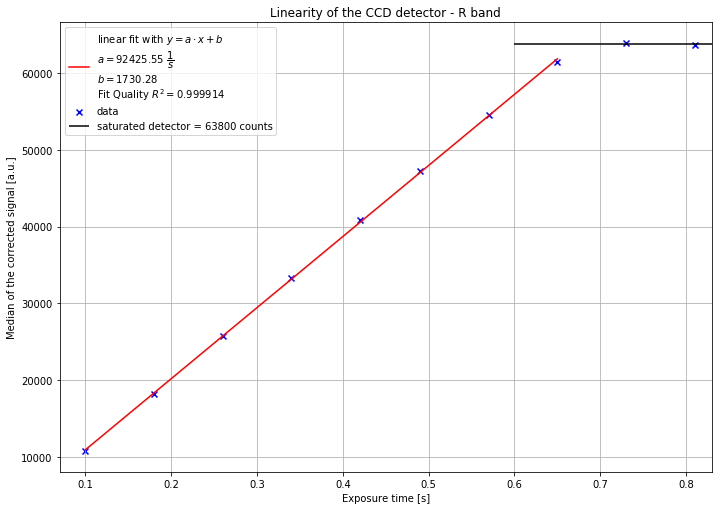

In [8]:
# from linearity measurement read exposure time 
path = r".\Template Scripts\linearity"
lin = IFC(path,glob_include='linearity_R_*',keywords=['exptime'])
exptime = lin.summary['exptime'].data

lin_med_ff = []
lin_stddev_ff = []

for idx, hdu in enumerate(lin.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    # bias correction
    bias = np.median(CCDData(hdu.data[0:1024,1025:1050], unit="electron"))
    dat.data = dat.data - bias
    # flat field correction
    dat.data = dat.divide(master_flat_R)
    lin_med_ff.append(np.nanmedian(dat.data))
    lin_stddev_ff.append(np.nanstd(dat.data))

# Verify the linearity of the chip by plotting the signal integration time
plt.scatter(exptime, lin_med_ff, marker='x', color='blue', label = 'data')
# Determine the deviation from a perfect linear relationship and specify the intensity at saturation 
slope, intercept, r_value, p_value, std_err = linregress(exptime[:-2], lin_med_ff[:-2])
plt.plot(exptime[:-2], slope*exptime[:-2]+intercept,color='red', label='\n'.join([
    "linear fit with $y = a \cdot x + b $",
    "$a = $"+str(round(slope,2))+r" $\dfrac{1}{s}$",
    "$b = $"+str(round(intercept,2)),
    "Fit Quality $R^2 = $"+str(round(r_value,6))]))
plt.hlines(np.average(lin_med_ff[-2:]),xmin=0.6,xmax=1, label='saturated detector = '+
          str(int(round(np.average(lin_med_ff[-2:]),-2)))+" counts")
plt.title("Linearity of the CCD detector - R band")
plt.ylabel("Median of the corrected signal [a.u.]")
plt.xlabel("Exposure time [s]")
plt.grid()
plt.legend()
plt.xlim(0.07,0.83)
plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig(r".\pictures\LinearityRFilter.png",)
plt.show()

# TODO: Estimate the error of the measurement from the standard deviation of the pixel values. (How?)

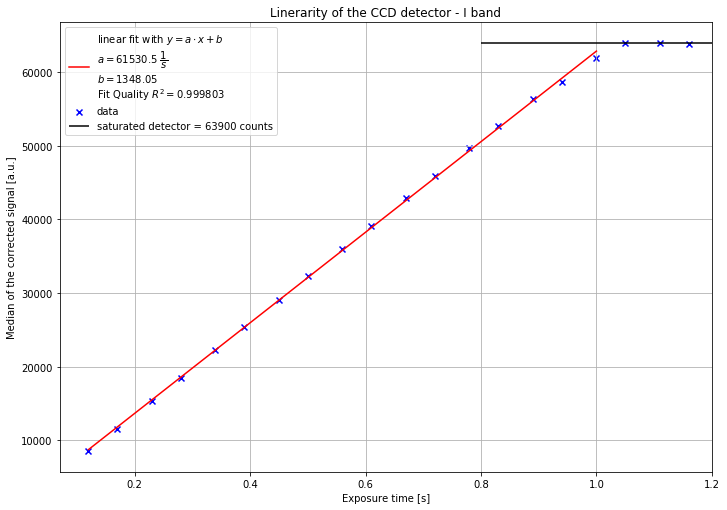

In [9]:
# from sensitivity measurement read exposure time 
# TODO: why it measured twice with _1_ and _2_ ?
path = r".\Template Scripts\sensitivity"
sen = IFC(path,glob_include='sensitivity_I_1_*',keywords=['exptime'])
sen2 = IFC(path,glob_include='sensitivity_I_2_*',keywords=['exptime'])
exptime_sen = sen.summary['exptime'].data


sen_med_ff = []
sen_stddev_ff = []

for idx, hdu in enumerate(sen.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    # bias correction
    bias = np.median(CCDData(hdu.data[0:1024,1025:1050], unit="electron"))
    dat.data = dat.data - bias
    # flat field correction
    dat.data = dat.divide(master_flat_I)
    sen_med_ff.append(np.nanmedian(dat.data))
    sen_stddev_ff.append(np.nanstd(dat.data))

# Verify the linearity of the chip by plotting the signal  against integration time
plt.scatter(exptime_sen, sen_med_ff,marker='x', color='blue', label = 'data')
# Determine the deviation from a perfect linear relationship and specify the intensity at saturation
slope, intercept, r_value, p_value, std_err = linregress(exptime_sen[:-3], sen_med_ff[:-3])
plt.plot(exptime_sen[:-3], slope*exptime_sen[:-3]+intercept,color='red', label='\n'.join([
    "linear fit with $y = a \cdot x + b $",
    "$a = $"+str(round(slope,2))+r" $\dfrac{1}{s}$",
    "$b = $"+str(round(intercept,2)),
    "Fit Quality $R^2 = $"+str(round(r_value,6))]))
plt.hlines(np.average(sen_med_ff[-3:]),xmin=0.8,xmax=1.3, label='saturated detector = '+
          str(int(round(np.average(sen_med_ff[-3:]),-2)))+" counts")
plt.legend()
plt.grid()
plt.xlim(0.07,1.2)
plt.title("Linerarity of the CCD detector - I band")
plt.ylabel("Median of the corrected signal [a.u.]")
plt.xlabel("Exposure time [s]")
plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig(r".\pictures\LinearityIFilter.png",)
plt.show()

# Estimate the error of the measurement from the standard deviation of the pixel values. (how?)

Let's take the seventh image Pair (_0006) for example:
the total noise:  264.3 ADU^0.5
the read-out noise:  43.1 ADU^0.5
the difference total noise:  75.9 ADU^0.5
the photon noise:  31.9 ADU^0.5
the PRNU noise:  258.8 ADU^0.5


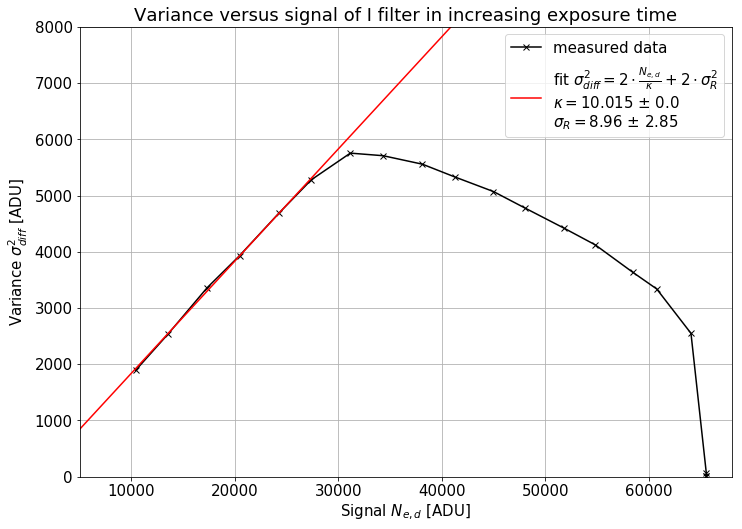

.... a =  0.19969892359833205 
.... b =  -160.70436040780797
Let's consider the same picture as above (_0006): 
 N =  31156 
 sig**2 =  31.92 
 with eq. 19 we calculate the gain to 
 k =  976.14


In [10]:
# Sensitivity of the detector and noise properties
# TODO: not so sure about that part
ita = 1. # the quantum efficiency, assuming = 1
kappa = 5. # electron seneitivity
f_PRNU = 0.01
xfit = np.linspace(500,6.8e4,100)
plt.rcParams.update({'font.size': 15})

# in the following sig_* meaning (sig_*)^2
N_e_d = []
N_e_d2 = []
sig_diff_list = []

for idx, (hdu, hdu2) in enumerate(zip(sen.hdus(),sen2.hdus())):
    dat = CCDData(hdu.data, unit="electron")
    dat2 = CCDData(hdu2.data, unit="electron")
    # subtract the signal of one image from the other
    diffdat = dat.subtract(dat2)
    # Choose at least a 200 x 200 pixel region that is uniformly illuminated near the center
    # in our case x[303:502] y[296:495], see pic "sensitivity_region"
    # extract median signal within the chosen regions
    N_e_d.append(np.median(dat[303:502, 296:495]))
    N_e_d2.append(np.median(dat2[303:502, 296:495]))
    sig_diff_list.append(np.std(diffdat[303:502, 296:495]))
    # Find and discuss the photon noise, the read-out noise, and the PRNU noise for one flat image
    if idx==6:
        print("Let's take the seventh image Pair (_0006) for example:")
        sig_tot1 = np.std(dat.data[303:502, 296:495])
        sig_tot2 = np.std(dat2.data[303:502, 296:495])
        sig_tot = 0.5*(sig_tot1 + sig_tot2)
        print("the total noise: ", round(sig_tot,1), "ADU^0.5")
        sig_R = np.std(dat.data[0:1024,1025:1050])
        print("the read-out noise: ", round(sig_R,1), "ADU^0.5")
        sig_diff = np.std(diffdat[303:502,296:495])
        print("the difference total noise: ", round(sig_diff,1), "ADU^0.5")
        sig_ed_ver1 = np.sqrt(-sig_R**2+0.5*sig_diff**2)
        print("the photon noise: ", round(sig_ed_ver1,1), "ADU^0.5")
        sig_prnu = np.sqrt(-sig_R**2-sig_ed_ver1**2+sig_tot**2)
        print("the PRNU noise: ", round(sig_prnu,1), "ADU^0.5")

N_e_d = np.asarray(N_e_d)
N_e_d2 = np.asarray(N_e_d2)
N_avg = 0.5*(N_e_d+N_e_d2)
sig_diff_list = np.asarray(sig_diff_list)

def linear(x,a,b):
    return a*x+b

para,pcov = curve_fit(linear, N_avg[:6], sig_diff_list[:6]**2,p0=[0.2,0])

#plt.vlines(N_avg[6],ymin=0,ymax=6e3)
plt.plot(N_avg,sig_diff_list**2,'kx-', label ='measured data' )
plt.plot(xfit, linear(xfit,*para),'r-', label='\n'.join([
    r"fit $\sigma^{2}_{diff} = 2 \cdot \frac{N_{e,d}}{\kappa} + 2 \cdot \sigma^{2}_{R}$",
    "$\kappa = $"+str(round(2/para[0],3))+" $\pm$ "+str(round(2*np.sqrt(pcov[0,0])/(2/para[0])**2,3)),
    "$\sigma_{R} = $"+str(round(np.sqrt(-para[1]/2),2))+" $\pm$ "
    +str(round(np.sqrt(pcov[1,1])/(2*np.sqrt(-para[1]/2)),2))]))
plt.title('Variance versus signal of I filter in increasing exposure time')
plt.legend()
plt.xlabel('Signal $N_{e,d}$ [ADU]')
plt.ylabel('Variance $\sigma^{2}_{diff}$ [ADU]')
plt.xlim(0.5e4,6.8e4)
plt.ylim(0,8e3)
plt.grid()
plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig(r".\pictures\Noise.png",)
plt.show()

print('.... a = ', para[0],'\n.... b = ', para[1])
print('Let\'s consider the same picture as above (_0006): \n N = ', int(round(N_avg[6],0)),
      '\n sig**2 = ',round(sig_ed_ver1,2), '\n with eq. 19 we calculate the gain to \n k = ',
      round(N_avg[6]/sig_ed_ver1,2))
# Calculate kappa using eq. 19 and explain discrepancies with previous method. 
# Do the calculation for just one image with average counts ~30000 ADU

# Discuss the quality of the analogue digital converter

# TODO: Which noise dominates? Explain.